# Part 4: Name Analyze

### In this part we analyze the name of the Kickstarter project.

## Imports & Configurations

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -O ./spark-3.3.1-bin-hadoop3.tgz  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar zxvf ./spark-3.3.1-bin-hadoop3.tgz
!pip install findspark
!pip install pyspark

--2023-02-26 10:27:26--  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-02-26 10:27:26 ERROR 404: Not Found.


gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import findspark
import random
import pyspark
import numpy as np # linear algebra

from pyspark.sql import SparkSession
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.ml.feature import VectorAssembler,Tokenizer,MinMaxScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.linalg import Vectors

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import time
import re
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords

from wordcloud import WordCloud

In [4]:
spark = SparkSession.builder.config("spark.driver.memory", "2g")\
    .config("spark.executor.memory", "2g") \
    .config('spark.executor.cores', '3') \
    .config('spark.cores.max', '3') \
    .appName("name").getOrCreate()

spark.conf.set("spark.sql.shuffle.partitions", 10)
spark.conf.set("spark.default.parallelism", 10)

## Read the Data

In [5]:
# Use Spark to read the csv file.
df = spark.read.csv("/content/drive/MyDrive/BDP Final Project/Notebooks/Data/categories_data.csv",
                    inferSchema=True,
                    header=True)

In [6]:
df.show(5)

+--------------------+-------------+----------+--------------------+--------------------+-------------+-----------+------------------+--------+-------+------+----------------+-------------------+--------------+-------------------+-----------------+-------------------+----------------------+----------------------+---------------------+------------+---------+----------+----------------+--------------------+-------------+----------------+-------------+------------------------------+------------------------------+----------+-----------+-------------------+--------------------------+--------------+----------------------+--------------------+-------------------+-------------------+------------------------------------+---------------------------+------------------+---------------+----------------+----------------------+----------------+-----------------+------------------------+----------------+-----------------------+-------------+--------------+---------------------+-------------+----------

#part 4.1 : Analyze Name

##Create helper function

Helper functions to find pattern in name:



In [7]:
IS_NOT_TIME =  {'miles', 'p', 'km', 'pi',  'b', 'whatever', 'nyc', 'x', 'tiny', 'inc', 'mah','ad'}
IS_URL = arr = {'www','.com','http','https','.org','.eu','.me','.net'}
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
STOPWORDS_EN = stopwords.words("english")


def is_hour(value):
    """Check if value is hour."""
    time_re = re.compile('^(2[0-3]|[01]?[0-9]):([0-5][0-9])$')
    return bool(time_re.match(value)) 

def is_date(value):
    """Check if value is date."""
    date_re = re.compile('(\d{4})[-\. ](\d{2})[-\. ](\d{2})|(\d{2})[-\. ](\d{2})[-\. ](\d{4})')
    return bool(date_re.match(value)) 

def is_year(value):
    """Check if value is year."""
    year_re = re.compile('[1-2][0-9]{3}')
    return bool(year_re.match(value))

def is_time_helper(value):
    return ( is_hour(value) |  is_date(value) |  is_year(value)) 

def is_time(value):
    """Check if value is time."""
    if is_time_helper(value) == False:
        return False
    for check in IS_NOT_TIME:
        if check in value: 
            return False
    return True

def is_number(value):
    """Check if value is number."""
    num_re = re.compile('[-+]?[0-9]*[\.\/\\]?[0-9]+$')
    return bool( num_re.match(value) )

def is_url(value):
    """Check if value is url."""
    for c in IS_URL:
        if c in value:
            return True
    
    if ('.' in value) & ('/' in value):
        return True
    
    url_re= re.compile('^(http:\/\/www\.|https:\/\/www\.|http:\/\/|https:\/\/)?[a-z0-9]+([\-\.]{1}[a-z0-9]+)*\.[a-z]{2,5}(:[0-9]{1,5})?(\/.*)?$}')
    return bool(url_re.match(value))
        
def is_symbol(value):
    """Check if value is symbol."""
    return len(re.sub(r'[A-Za-z0-9 ]+', '', value)) == len(value)
        
def is_stopword(value):
    """Check if value is stopword."""
    if value in STOPWORDS_EN:
        return True
    return False

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Helper functions for cleaning tokenized name:

In [8]:
def clean_value_to_array(value):
    """Clean the value and return as array"""
    res = {''}
    value = nltk.WordNetLemmatizer().lemmatize(value)
    value = nltk.WordPunctTokenizer().tokenize(value)
    for x in value:
        res.update(re.findall(r'[a-z]+', re.sub(r'[^a-z]+',' ',x.lower())))
        res.update(re.findall(r'[0-9]+', re.sub(r'[^0-9]+',' ',x.lower())))
        for c in x.lower().strip():
            if c.isalnum() == False:
                res.update(c)
    res.remove('')
    return res


def tokenized_name_cleaner(arr):
    """Clean the tokenized name values"""
    res = []
    for value in arr:
        if(is_url(value)):
            res.append('has_url')
        elif is_time(value):
            res.append('has_time')
        elif is_time(value):
            res.append('has_number')
        else:
            for x in clean_value_to_array(value):
                if x != '':
                    res.append(x)
    return res

## Tokenized Name

Adding new columns:   
   
1. **tokenized_name:** words tokenized from name of projects.

1. **clean_tokenized_name:** words tokenized from name of projects after cleaning time, url , and split all symbols and numbers.

In [9]:
tokenizer = Tokenizer(outputCol="tokenized_name", inputCol='name')
df = tokenizer.transform(df)

In [10]:
tokenizer = Tokenizer(outputCol="tokenized_blurb", inputCol='blurb')
df = tokenizer.transform(df)

In [11]:
tokenized_name_cleaner_udf = F.udf(tokenized_name_cleaner, ArrayType(StringType()))
df = df.withColumn('clean_tokenized_name', tokenized_name_cleaner_udf(F.col('tokenized_name')))
df = df.withColumn('clean_tokenized_blurb', tokenized_name_cleaner_udf(F.col('tokenized_blurb')))

In [12]:
df.show(5)

+--------------------+-------------+----------+--------------------+--------------------+-------------+-----------+------------------+--------+-------+------+----------------+-------------------+--------------+-------------------+-----------------+-------------------+----------------------+----------------------+---------------------+------------+---------+----------+----------------+--------------------+-------------+----------------+-------------+------------------------------+------------------------------+----------+-----------+-------------------+--------------------------+--------------+----------------------+--------------------+-------------------+-------------------+------------------------------------+---------------------------+------------------+---------------+----------------+----------------------+----------------+-----------------+------------------------+----------------+-----------------------+-------------+--------------+---------------------+-------------+----------

## Read helper data

#### Positive and negative words dataset
* link to data : https://www.kaggle.com/syhens/sentiment-words

In [13]:
def get_words_data_from_csv(csv_path, column_name):
    """Read dataframe and select a column from ir to return as array"""
    data = spark.read.csv(csv_path, inferSchema=True,header=True, escape='"')
    data = data.withColumn(column_name, F.lower(F.col(data.columns[0])))
    data = data.select(column_name).rdd.flatMap(lambda x: x).collect()
    return data


In [14]:
negative_words_data = get_words_data_from_csv(\
    '/content/drive/MyDrive/BDP Final Project/Notebooks/Data/Words/negative-words.csv', 'negative')

def is_negative_word(word):
    if word in negative_words_data:
      return 1
    return 0

In [15]:
positive_words_data = get_words_data_from_csv(\
    '/content/drive/MyDrive/BDP Final Project/Notebooks/Data/Words/positive-words.csv', 'positive')

def is_positive_word(word):
    if word in positive_words_data:
      return 1
    return 0

#### Frequency words dataset
* link to data : https://www.kaggle.com/rtatman/english-word-frequency/

In [16]:
csv_path = '/content/drive/MyDrive/BDP Final Project/Notebooks/Data/Words//unigram_freq.csv'
frequency_df = spark.read.csv(csv_path, inferSchema=True,header=True, escape='"')
assembler = VectorAssembler(inputCols=["count"], outputCol="count_vec")
scaler = MinMaxScaler(inputCol="count_vec", outputCol="count_scaled")
pipeline = Pipeline(stages=[assembler, scaler])
scalerModel = pipeline.fit(frequency_df)
frequency_df = scalerModel.transform(frequency_df)

In [17]:
frequency_df = frequency_df.select(
    F.col('word'),
    (vector_to_array(F.col('count_scaled'))[0]).alias('frequency')
)
words_frequency_values_list = [{r['word']: r['frequency']} for r in frequency_df.collect()]
frequency_data = {list(x.keys())[0]: x[list(x.keys())[0]] for x in words_frequency_values_list}


def get_frequency_value(word):
    try:
        return frequency_data[word.lower()]
    except:
        return 0

#### Buzzwords words dataset
* This dataset was created by collecting data from the internet

In [18]:
buzzwords_words_data = get_words_data_from_csv(\
    '/content/drive/MyDrive/BDP Final Project/Notebooks/Data/Words/buzzwords.csv', 'buzzwords')

def is_buzzword(word):
    if nltk.WordNetLemmatizer().lemmatize(word).lower() in buzzwords_words_data:
        return 1
    return 0

##create helper dataset - word_df

In [19]:
data = df.select(F.explode(F.col('clean_tokenized_name')).alias('word'))
data = data.select('word').rdd.flatMap(lambda x: x).collect()

In [20]:
words_data = []

for x in data:
  if (is_time(x) == False) & (is_url(x) == False) & (is_number(x) == False) & (is_stopword(x) == False):
    words_data.append(x.lower())

In [21]:
fdist = FreqDist(words_data)
word_df = spark.createDataFrame(list(fdist.items()), ["word", "frequency"])

In [22]:
word_df = word_df.withColumn('length', F.length(F.col('word')))

In [23]:
df_success = df.select(
  F.explode(F.col('clean_tokenized_name')).alias('word')
)\
.where(F.col('state') == 'successful').groupBy('word').count()
df_success = df_success.withColumnRenamed('count','count_of_success')
word_df = word_df.join(df_success,'word','left')

In [24]:
word_df = word_df.withColumn(
    'word_success_percent', F.col('count_of_success') / F.col('frequency')
)

In [25]:
is_positive_word_udf = F.udf(lambda z: is_positive_word(z), T.IntegerType())   
is_negative_word_udf = F.udf(lambda z: is_negative_word(z), T.IntegerType())   
is_buzzword_udf = F.udf(lambda z: is_buzzword(z), T.IntegerType())   
get_frequency_value_udf = F.udf(lambda z: get_frequency_value(z), T.DoubleType())   

word_df = word_df\
.withColumn("is_positive_word", is_positive_word_udf(F.col("word")))\
.withColumn("is_negative_word", is_negative_word_udf(F.col("word")))\
.withColumn("is_buzzword", is_buzzword_udf(F.col("word")))\
.withColumn("frequency_value", get_frequency_value_udf(F.col("word")))
  

In [26]:
word_df.show()

+-----------+---------+------+----------------+--------------------+----------------+----------------+-----------+--------------------+
|       word|frequency|length|count_of_success|word_success_percent|is_positive_word|is_negative_word|is_buzzword|     frequency_value|
+-----------+---------+------+----------------+--------------------+----------------+----------------+-----------+--------------------+
|      lafee|        1|     5|            null|                null|               0|               0|          0|                null|
|photography|      808|    11|             286| 0.35396039603960394|               0|               0|          0|0.002380343989548...|
|   portrait|      392|     8|             238|  0.6071428571428571|               0|               0|          0|4.596559585477372E-4|
|  antartica|        1|     9|               1|                 1.0|               0|               0|          0|6.504843138438113E-6|
|  patagonia|       10|     9|               6| 

#Part 4.2: Add new Columns to Dataframe

In [27]:
def create_clean_tokenized_name_length(df):
  """Add clean tokenized name length column to dataframe."""
  return df.withColumn('clean_tokenized_name_length', F.size(F.col('clean_tokenized_name')))

df = df.transform(create_clean_tokenized_name_length)

In [28]:
def create_tokenized_name_length(df):
    """Add tokenized name length column to dataframe."""
    return df.withColumn('tokenized_name_length', F.size(F.col('tokenized_name')))
  
df = df.transform(create_tokenized_name_length)

In [29]:
def create_clean_tokenized_blurb_length(df):
    """Add clean tokenized blurb length column to dataframe."""
    return df.withColumn('clean_tokenized_blurb_length', F.size(F.col('clean_tokenized_blurb')))

df = df.transform(create_clean_tokenized_blurb_length)

In [30]:
def create_tokenized_blurb_length(df):
    """Add tokenized blurb length column to dataframe."""
    return df.withColumn('tokenized_blurb_length', F.size(F.col('tokenized_blurb')))
  
df = df.transform(create_tokenized_blurb_length)

In [31]:
def create_name_length(df):
    """Add name length column to dataframe."""
    return df.withColumn('name_length', F.length(F.col('name')))

df = df.transform(create_name_length)

In [32]:
def create_blurb_length(df):
    """Add blurb length column to dataframe."""
    return df.withColumn('blurb_length', F.length(F.col('blurb')))

df = df.transform(create_blurb_length)

In [33]:
def get_words_len_mean(arr):
    """Returns mean of words length."""
    sumLen = 0 
    for value in arr:
        sumLen += len(value)
    try:
        return sumLen / len(arr)
    except:
        return 0 

def create_words_len_mean(df):
    """Add mean words length column to dataframe."""
    get_words_len_mean_udf = F.udf(lambda z: get_words_len_mean(z), T.DoubleType())   
    return df.withColumn("words_len_mean", get_words_len_mean_udf(F.col("tokenized_name")))

df = df.transform(create_words_len_mean)

In [34]:
def number_counter(arr):
    """Returns count of number values."""
    counter = 0 
    for x in arr:
        if is_number(x):
            counter+=1
    return counter

def create_name_number_count(df):
    """Add name number count column to dataframe."""
    number_counter_udf = F.udf(lambda z:number_counter(z),T.IntegerType())   
    return df.withColumn("name_number_count", number_counter_udf(F.col("tokenized_name")))

df = df.transform(create_name_number_count)

In [35]:
def time_counter(arr):
    """Returns count of time values."""
    counter = 0 
    for x in arr:
        if is_time(x):
            counter+=1
    return counter

def create_name_time_count(df):
    """Add name time count column to dataframe."""
    time_counter_udf = F.udf(lambda z:time_counter(z),T.IntegerType())   
    return df.withColumn("name_time_count", time_counter_udf(F.col("tokenized_name")))

df = df.transform(create_name_time_count)


In [36]:
def url_counter(arr):
    """Returns count of url values."""
    counter = 0 
    for x in arr:
        if is_url(x):
            counter+=1
    return counter

def create_name_url_count(df):
    """Add name url count column to dataframe."""
    url_counter_udf = F.udf(lambda z:url_counter(z),T.IntegerType())   
    return df.withColumn("name_url_count", url_counter_udf(F.col("tokenized_name")))

df = df.transform(create_name_url_count)

In [37]:
def stop_word_counter(arr):
    """Returns count of stopword values."""
    counter = 0
    for x in arr:
        if is_stopword(x):
            counter += 1
    return counter
        
def create_stopword_count(df):
    """Add name stopword count column to dataframe."""
    stop_word_counter_udf = F.udf(lambda z:stop_word_counter(z),T.IntegerType())    
    return df.withColumn("stopword_count", stop_word_counter_udf(F.col("tokenized_name")))

df = df.transform(create_stopword_count)

In [38]:
def symbol_counter(arr):
    """Returns count of symbol values."""
    counter = 0
    for x in arr:
        if is_symbol(x):
            counter += 1
    return counter

def create_symbol_count(df):
    """Add name stopword count column to dataframe."""
    symbol_counter_udf = F.udf(lambda z:symbol_counter(z),T.IntegerType())   
    return df.withColumn("symbol_count", symbol_counter_udf(F.col("tokenized_name")))

df = df.transform(create_symbol_count)

In [39]:
def create_name_is_question(df):
    """Add name is question column to dataframe."""
    return df.withColumn("name_is_question", F.when(F.col('name').endswith('?'),1).otherwise(0))

def create_name_is_exclamation(df):
    """Add name is exclamation column to dataframe."""
    return df.withColumn("name_is_exclamation", F.when(F.col('name').endswith('!'),1).otherwise(0))


df = df.transform(create_name_is_question)
df = df.transform(create_name_is_exclamation)

In [40]:
def name_is_upper(name):
    """Check if name is uppercase."""
    return name.isupper()

def create_name_is_upper(df):
    """Add name is uppercase column to dataframe."""
    name_is_upper_udf = F.udf(lambda z:name_is_upper(z),T.BooleanType())   
    return df.withColumn("name_is_upper", name_is_upper_udf(F.col("name")).cast('int'))

df = df.transform(create_name_is_upper)


In [43]:
def negative_words_counter(arr):
    """Returns count of negative words."""
    counter = 0
    for value in arr:        
        if is_negative_word(value):
            counter+=1
    return counter

def create_name_negative_count(df):
    """Add name negative words count column to dataframe."""
    negative_words_counter_udf = F.udf(lambda z:negative_words_counter(z),T.IntegerType())   
    return df.withColumn("name_negative_count", negative_words_counter_udf(F.col("clean_tokenized_name")))

df = df.transform(create_name_negative_count)

In [44]:
def positive_words_counter(arr):
    """Returns count of positive words."""
    counter = 0
    for value in arr:        
        if is_positive_word(value):
            counter+=1
    return counter


def create_name_positive_count(df):
    """Add name positive words count column to dataframe."""
    positive_words_counter_udf = F.udf(lambda z:positive_words_counter(z),T.IntegerType())   
    return  df.withColumn("name_positive_count", positive_words_counter_udf(F.col("clean_tokenized_name")))

df = df.transform(create_name_positive_count)

In [45]:
def buzzwords_counter(arr):
    """Returns count of buzzwords."""
    counter = 0
    for value in arr:        
        if is_buzzword(value):
            counter+=1
    return counter

def create_name_buzzwords_count(df):
    """Add name buzzwords count column to dataframe."""
    buzzwords_counter_udf = F.udf(lambda z:buzzwords_counter(z),T.IntegerType())   
    return df.withColumn("name_buzzwords_count", buzzwords_counter_udf(F.col("clean_tokenized_name")))

df = df.transform(create_name_buzzwords_count)

In [46]:
def get_name_frequency_value(values):
    """Returns frequency value of words in the name."""
    sumValues = 0 
    if len(values) ==0:
        return 0
    for x in values:
        sumValues += get_frequency_value(x)         
    return sumValues / len(values)

def create_name_frequency_value(df):
    """Add name frequency value column to dataframe."""
    get_name_frequency_value_udf = F.udf(lambda z:get_name_frequency_value(z),T.DoubleType())   
    return df.withColumn("name_frequency_value", get_name_frequency_value_udf(F.col("clean_tokenized_name")))

df = df.transform(create_name_frequency_value)

In [47]:
word_success_value = {}

word_success_value_df = word_df.select(
    F.col('word_success_percent'),
    F.col('word')
)
word_success_value_list = [{r['word']: r['word_success_percent']} for r in word_success_value_df.collect()]
word_success_value = {list(x.keys())[0]: x[list(x.keys())[0]] for x in word_success_value_list}

def get_success_value(values):
    """ Get success value of the words in the name.
        Calculated by sum of success values divided by the length.
    """
    sumValues = 0 
    lenValues= 0
    for x in values:
        if (is_time(x) == False) &  (is_url(x) == False) &  (is_number(x) == False) :
            try:
                sumValues += word_success_value[x]
                lenValues+= 1
            except:
                sumValues +=0
    try:
        return sumValues / lenValues
    except:
        return 0
    
def create_name_success_value(df):
    """Add name success value column to dataframe."""
    get_success_value_udf = F.udf(lambda z:get_success_value(z),T.DoubleType())   
    return df.withColumn("name_success_value", get_success_value_udf(F.col("clean_tokenized_name")))

df = df.transform(create_name_success_value)

In [48]:
df.show()

+--------------------+-------------+----------+--------------------+--------------------+-------------+-----------+------------------+--------+-------+-------+----------------+-------------------+--------------+-------------------+-----------------+-------------------+----------------------+----------------------+---------------------+------------+---------+----------+----------------+--------------------+-------------+----------------+-------------+------------------------------+------------------------------+----------+-----------+-------------------+--------------------------+--------------+----------------------+--------------------+-------------------+-------------------+------------------------------------+---------------------------+------------------+---------------+----------------+----------------------+----------------+-----------------+------------------------+----------------+-----------------------+-------------+--------------+---------------------+-------------+---------

In [49]:
df_to_write = df.drop('tokenized_name','tokenized_blurb','clean_tokenized_name','clean_tokenized_blurb')

In [50]:
df_to_write.write.csv("/content/drive/MyDrive/BDP Final Project/Notebooks/Data/name_data.csv", header=True, mode ="overwrite")

#Part 4.3: Visualization

In [51]:
def plot_word_cloud(column, data=word_df):
    """Plot word cloud of popular words."""
    data = data.toPandas()
    values = data.sort_values(by=column,ascending=False).word.iloc[:100]
    cleaned_word = " ".join([word for word in values])
    wordcloud = WordCloud(background_color='white',
                      width=2500,
                      height=2000,
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(12, 12))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()  


plot most common words

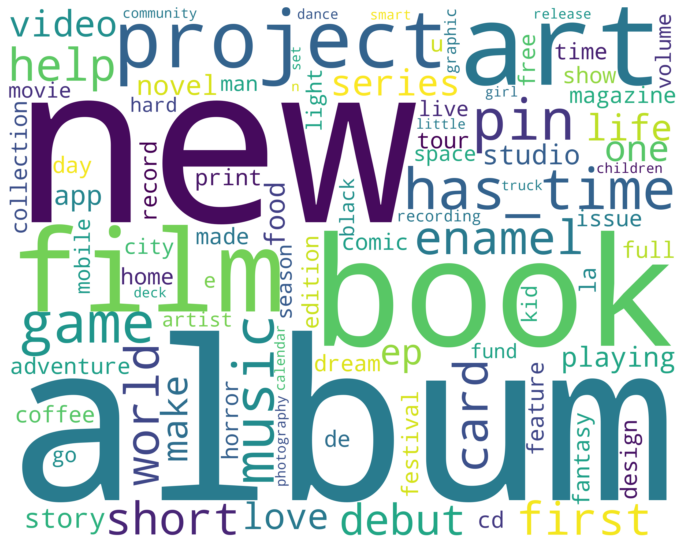

In [52]:
plot_word_cloud('frequency')

plot words that have more successful projects

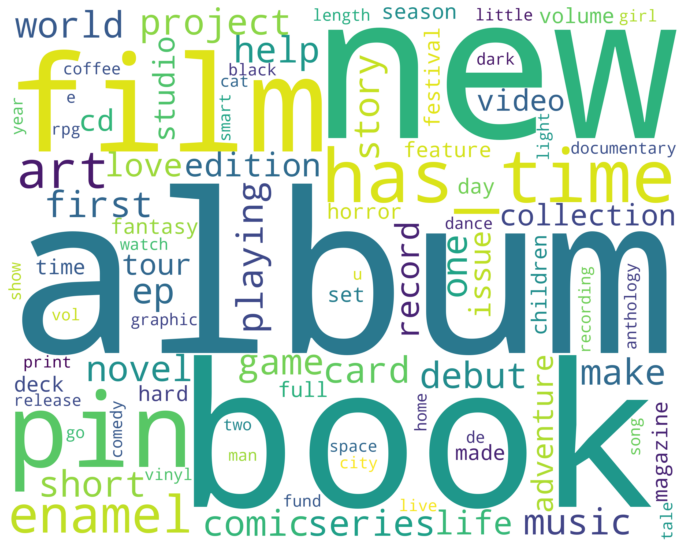

In [53]:
plot_word_cloud('count_of_success')

plot words that get highest success value

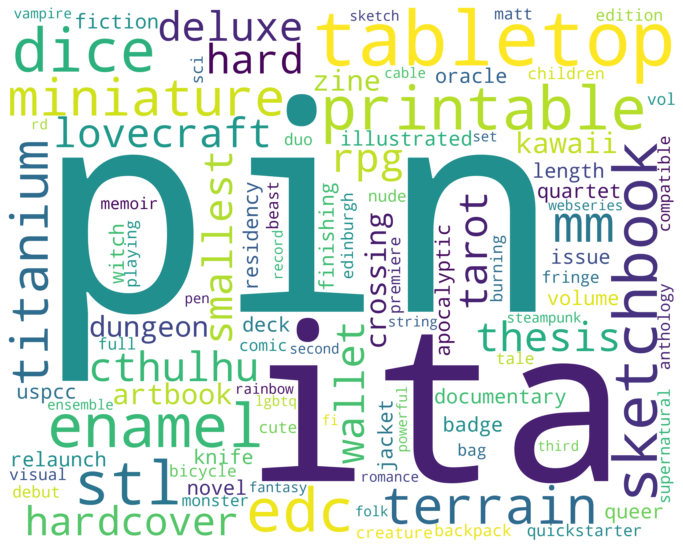

In [54]:
plot_word_cloud('word_success_percent', word_df.where(F.col('frequency') >=100))

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

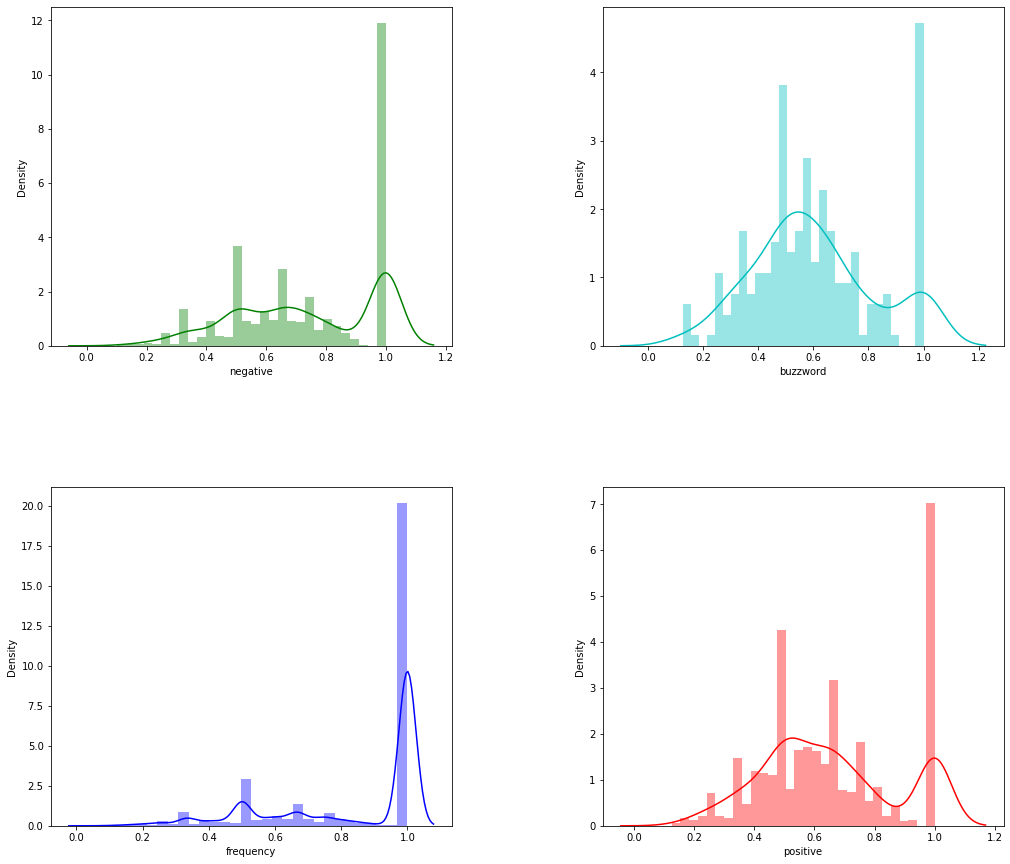

In [55]:
buzzword = word_df.where(F.col('is_buzzword') == 1).select('word_success_percent').rdd.flatMap(lambda x: x).collect()
frequency = word_df.where(F.col('frequency') > 0).select('word_success_percent').rdd.flatMap(lambda x: x).collect()
positive = word_df.where(F.col('is_positive_word') == 1).select('word_success_percent').rdd.flatMap(lambda x: x).collect()
negative = word_df.where(F.col('is_negative_word') == 1).select('word_success_percent').rdd.flatMap(lambda x: x).collect()

fig , ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(17,15))

fig.tight_layout(pad=12.0)
sns.distplot(negative, bins=30, norm_hist=True, color = 'g', ax=ax1 , axlabel='negative')
sns.distplot(buzzword, bins=30, norm_hist=True, color = 'c', ax=ax2, axlabel='buzzword')
sns.distplot(frequency, bins=30, norm_hist=True, color = 'b', ax=ax3, axlabel='frequency')
sns.distplot(positive, bins=30, norm_hist=True, color = 'r', ax=ax4, axlabel='positive')

plt.show()

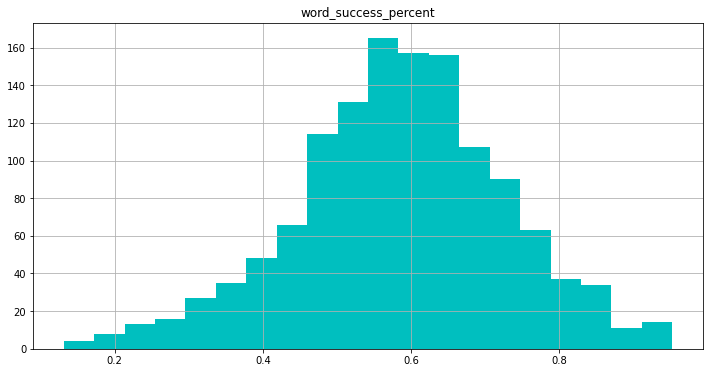

In [56]:
word_df.where(F.col('frequency') >=100).select('word_success_percent').toPandas().hist(bins= 20, color = 'c', figsize=(12,6))
plt.show()

In [57]:
def plot_column_state_compare(data,column, hue = 'state'):
    """Plot state compare of given column of the dataframe."""
    fig, ax = plt.subplots(1,1, figsize=(12,10))
    plt.subplot(212)
    ax = sns.countplot(x=column, hue=hue, data=data.toPandas() , palette='GnBu' )
    ax.set_title("Projects count by " + str(column), fontsize=22)
    ax.set_xlabel(str(column), fontsize=17)
    ax.set_ylabel("Count", fontsize=17),
    ax.legend(loc='upper right')
    plt.subplots_adjust(hspace = 0.4)
    plt.show()

Plotting count words len mean - successful compare failed:

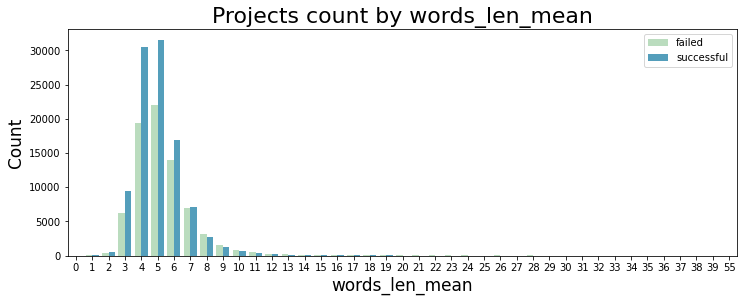

In [58]:
data = df.withColumn('words_len_mean', F.col('words_len_mean').cast('int'))

plot_column_state_compare(data, 'words_len_mean')

Plotting count words in name - successful compare failed:

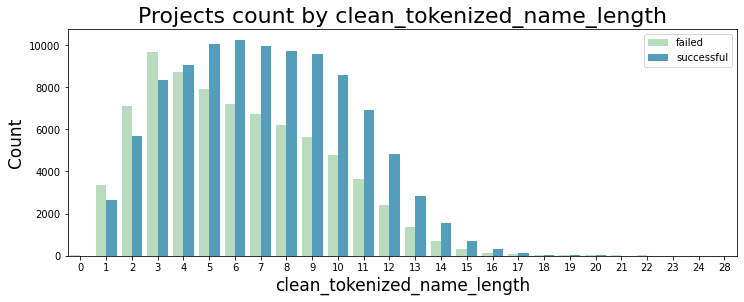

In [59]:
plot_column_state_compare(df, 'clean_tokenized_name_length')

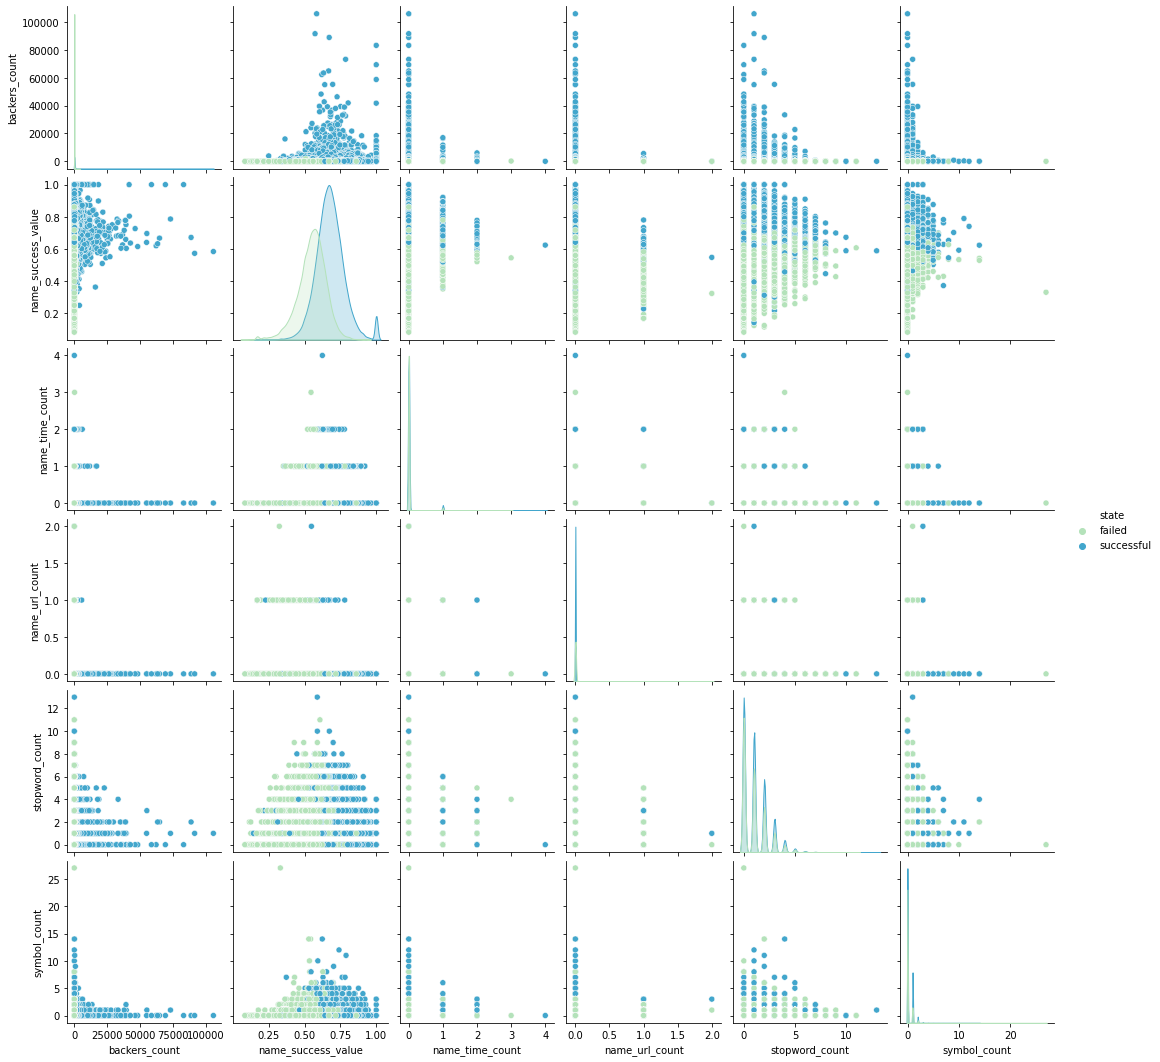

In [60]:
data = df.select('state','backers_count','name_success_value','name_time_count','name_url_count','stopword_count',
                  'symbol_count')

sns.pairplot(data.toPandas(), hue='state', palette = 'GnBu')
plt.show()

Plotting impact of words len mean on name success value:


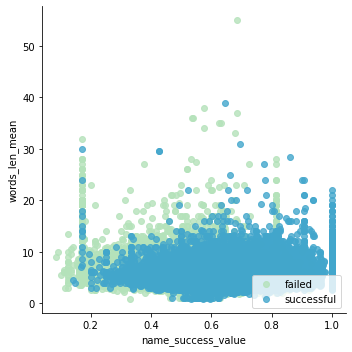

In [61]:
sns.lmplot( x="name_success_value", y="words_len_mean", data=df.toPandas(), fit_reg=False, hue='state',
           legend=False,palette='GnBu')
plt.legend(loc='lower right')
plt.show()

Plotting impact of words len mean on backers:

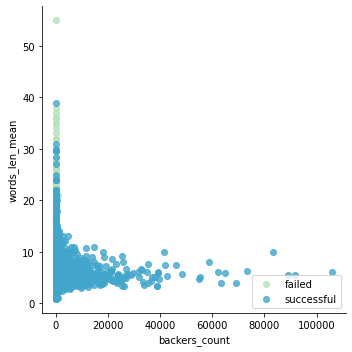

In [62]:
sns.lmplot( x="backers_count", y="words_len_mean", data=df.toPandas(), fit_reg=False, hue='state',
           legend=False,palette='GnBu')
plt.legend(loc='lower right')
plt.show()

Plotting impact of question mark on backers, name_success_value and state:



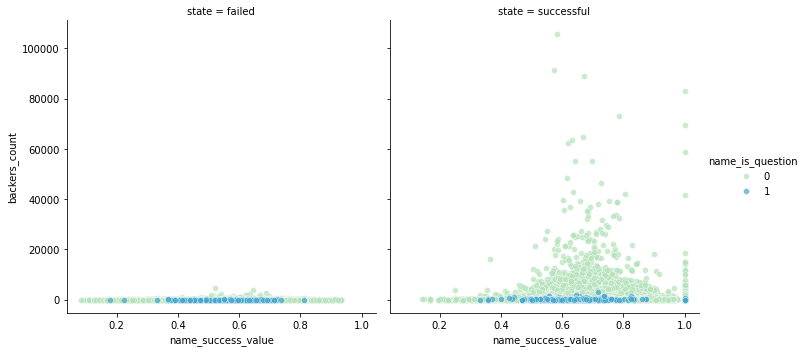

In [63]:
g = sns.FacetGrid(df.toPandas(), col="state", hue="name_is_question", palette='GnBu', height=5)
g.map(plt.scatter, "name_success_value", "backers_count", alpha=.7, linewidth=.5, edgecolor="white")
g.add_legend()
plt.show()

Plotting impact of exclamation mark on backers, name_success_value and state:



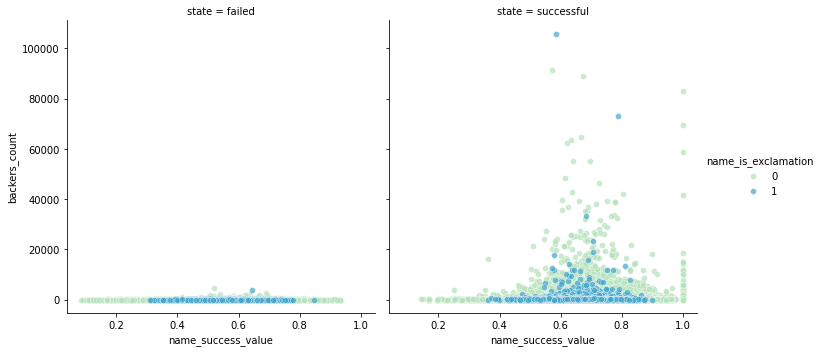

In [64]:
g = sns.FacetGrid(df.toPandas(), col="state", hue="name_is_exclamation", palette='GnBu', height=5)
g.map(plt.scatter, "name_success_value", "backers_count", alpha=.7, linewidth=.5, edgecolor="white")
g.add_legend()
plt.show()

Plotting impact of upper name mark on backers, name_success_value and state:

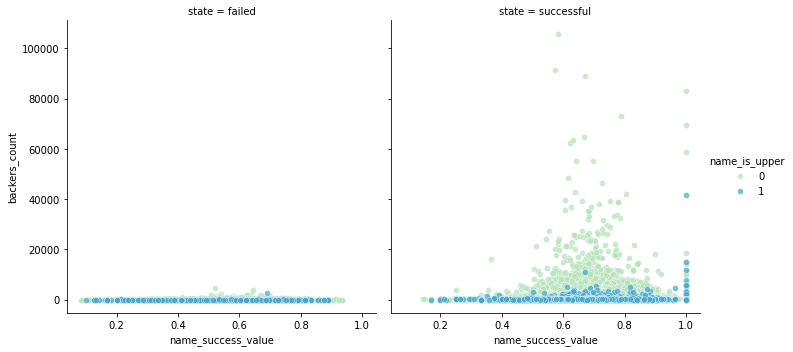

In [65]:
g = sns.FacetGrid(df.toPandas(), col="state", hue="name_is_upper", palette='GnBu', height=5)
g.map(plt.scatter, "name_success_value", "backers_count", alpha=.7, linewidth=.5, edgecolor="white")
g.add_legend()
plt.show()

Plotting impact of name_success_value on backers and state:

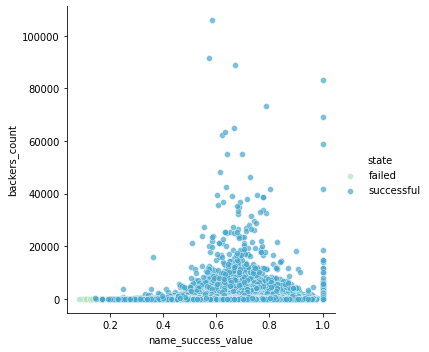

In [66]:
g = sns.FacetGrid(df.toPandas() ,hue="state", palette='GnBu', height=5)
g.map(plt.scatter, "name_success_value", "backers_count", alpha=.7, linewidth=.5, edgecolor="white")
g.add_legend()
plt.show()

In [67]:
spark.stop()

# Part 4.4: Conclusion

### * Choose a name with at least 6-7 words (but not too much more then that).
### * Don't use short words or too long words.
### * It's reccomended to use frequency words.
### * Symbol and stopwords are good, but not too much.
###  * Name that end with exclamation get more backers then name that end with question and when name is uppercase.